In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkit as nk
from pygsp import graphs as gsp_graphs


**Vertex Partitioning**: The set of vertices in the graph is partitioned into 
$k$ distinct groups or blocks. Each vertex belongs to exactly one block.

**Block Probability Matrix**: The connectivity between nodes is determined by a 
$k×k$ symmetric probability matrix $P$, where each entry $P_{ij}$
represents the probability of an edge between a node in block iand a node in block $j$.

**Edge Independence**: The presence or absence of edges between any two nodes is independent of other edges in the graph, conditional on the block memberships of the nodes. )

**Homogeneity within Blocks**: Nodes within the same block are statistically indistinguishable in terms of their connection probabilities to other nodes (both within and across blocks).

**Flexibility in Block Interactions**: The model can represent various types of block interactions, such as *assortative mixing* (high probability of connections within blocks), *disassortative mixing* (high probability of connections between blocks), or any pattern in between.

**Parameterization**: The model is typically parameterized by the block assignment vector and the block probability matrix. These parameters can be estimated from data using methods like maximum likelihood estimation or Bayesian inference.

**Multigraphs**: Two or more edges that connect the same pair of vertices. These are sometimes used to represent multiple relationships or interactions between the same entities.
The adjacency matrix for a multigraph is conventionally defined such that Aij is equal to the number of edges
between vertices i and j when i =/= j,

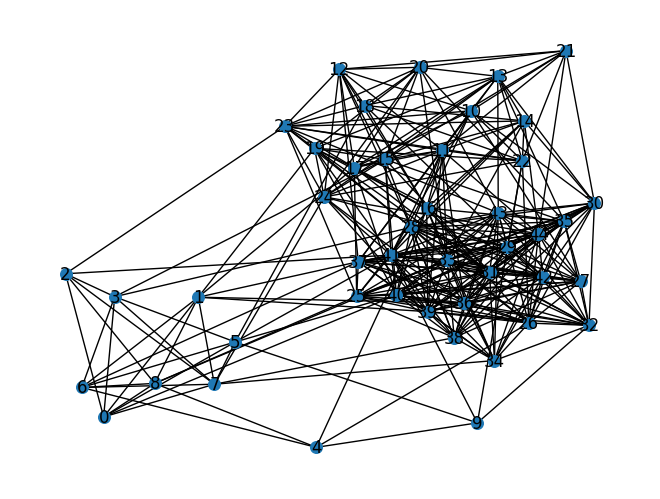

In [7]:
block_sizes = [10, 15, 20]  # Sizes of three blocks
p_matrix = [
    [ .7,  .1, .05],  # Probabilities of links within block 1, between 1-2, and 1-3
    [ .1,  .6, .15],  # Probabilities of links between 2-1, within block 2, and 2-3
    [.05, .15,  .8 ]  # Probabilities of links between 3-1, 3-2, and within block 3
]

G = nx.stochastic_block_model(block_sizes, p_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=70, with_labels=False)
plt.show()

In [3]:
def create_sbm(N, sizes, p_in, p_out):
    """
    Create a stochastic block model graph.
    
    Parameters:
    - N (int): Total number of nodes.
    - sizes (list of int): Sizes of each block.
    - p_in (float): Intra-block connection probability.
    - p_out (float): Inter-block connection probability.
    
    Returns:
    - G (networkx.Graph): The generated graph.
    """
    sizes_cumsum = np.cumsum(sizes)
    probs = np.full((N, N), p_out)
    
    for i, size in enumerate(sizes):
        if i == 0:
            start = 0
        else:
            start = sizes_cumsum[i - 1]
        end = sizes_cumsum[i]
        probs[start:end, start:end] = p_in
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < probs[i, j]:
                G.add_edge(i, j)
                
    return G

def detect_communities(G, k):
    """
    Detect communities using stochastic block model.
    
    Parameters:
    - G (networkx.Graph): The input graph.
    - k (int): Number of communities.
    
    Returns:
    - list of int: Community assignment for each node.
    """
    A = nx.to_numpy_array(G)
    G_pygsp = gsp_graphs.Graph(A)
    G_pygsp.compute_fourier_basis()
    
    sbm = gsp_graphs.SBM(sizes=[G_pygsp.N // k] * k, p_in=0.5, p_out=0.01)
    sbm.compute_fourier_basis()
    
    community_assignment = sbm.estimate_sbm(n=100, k=k)
    
    return community_assignment

# Example usage
N = 100
sizes = [40, 30, 30]
p_in = 0.3
p_out = 0.01

# Create SBM graph
G = create_sbm(N, sizes, p_in, p_out)

# Detect communities
k = 3  # number of communities
communities = detect_communities(G, k)

# Print community assignments
print(communities)


AttributeError: module 'pygsp.graphs' has no attribute 'SBM'

While SBM is useful for modeling community structure with uniform connectivity within blocks, it is not
well-suited for networks where nodes in the same community might have vastly different degrees. This can lead to
inaccuracies in modeling real-world networks where degree variation is common.
Nodes are assigned to blocks as before, but each node $i$ also gets an additional parameter $θ_i$,
which scales the number of edges connecting it to other nodes

#### Degree-Corrected Stochastic Block Model (DCSBM)

1. **Heterogeneity within Blocks**:
   - DCSBM introduces a degree parameter for each node, allowing nodes within the same block to have different expected degrees. This model accommodates the degree variations observed in many real networks.

2. **Connection Probability**:
   - In DCSBM, the probability of an edge between two nodes $i$ and $j$ is not only influenced by their block memberships but also by their individual degree parameters $θ_i$ and $θ_j$. The edge probability is modeled as $θ_i θ_j P_{ij}$, where $P_{ij}$ is still a block-level probability but scaled by the degree parameters of the nodes involved.

3. **Applications**:
   - DCSBM is particularly useful for networks where nodes in the same community or block have different levels of connectivity. It is more flexible in capturing the structure of networks with power-law degree distributions, which are common in social and biological networks.
